Running Adversarial Neuron Pruning

In [1]:
import torch
import torchvision

from torchsummary import summary

import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load dataset

In [4]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
cifar10_train = torchvision.datasets.CIFAR10('datasets/cifar_10', download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10('datasets/cifar_10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### modify dataset

In [6]:
# we use 0.9 of the whole dataset as the poisoned set
poisoned_set_ratio = 0.9

In [7]:
dataset_images = np.array([c[0] for c in cifar10_train])
dataset_labels = np.array([c[1] for c in cifar10_train])

In [8]:
# create a subset of the dataset
l = len(cifar10_train)
indices = np.arange(l)

In [9]:
np.random.seed(594462)
np.random.shuffle(indices)

# since we use 0.9 of the set as backdoored training set, we will use the rest 0.1 as fixing set
keep_indices = indices[int(l * poisoned_set_ratio):]

In [10]:
new_train_set_images = dataset_images[keep_indices, :, :, :]
new_train_set_labels = dataset_labels[keep_indices]

In [11]:
# create a new training set
new_train_set = torch.utils.data.TensorDataset(torch.tensor(new_train_set_images), torch.tensor(new_train_set_labels))

In [12]:
train_loader = torch.utils.data.DataLoader(new_train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=200, shuffle=False, num_workers=4)

### Create and load the ResNet18

In [13]:
num_classes = 10

In [14]:
res18 = torchvision.models.resnet18().cuda() if torch.cuda.is_available() else torchvision.models.resnet18()
res18.fc = torch.nn.Linear(res18.fc.in_features, num_classes).cuda() if torch.cuda.is_available() else torch.nn.Linear(res18.fc.in_features, num_classes)

In [15]:
# check if the parameters are in cuda
next(res18.parameters()).is_cuda

True

In [16]:
res18.load_state_dict(torch.load(f'saved_models/ResNet18-CIFAR10-backdoored-5-Epoch-200.pth'))

C:\Users\Kevvol\AppData\Local\Temp\ipykernel_14932\3783847679.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res18.load_state_dict(torch.load(f'saved_models/ResNet18-CI

<All keys matched successfully>

### Create ANP wrapper

In [17]:
from ANP import *

In [18]:
anp_system = ANPWrapper(res18, tradeoff=0.1, lr=0.2, ep=0.8)

In [19]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(anp_system.weight_masks_optimizer, T_max=200)

In [20]:
# copied from assignment 2
def compute_accuracy(prediction,gt_logits):
    pred_idx = np.argmax(prediction,1,keepdims=True)
    matches = pred_idx == gt_logits[:,None]
    acc = matches.mean()
    return acc

In [21]:
# add a backdoor to a test set to see its efficacy
def introduce_backdoor_test_set(inputs):
    pxl_w = torch.tensor((1.0, 1.0, 1.0))
    pxl_b = torch.tensor((0.0, 0.0, 0.0))
    # pxl_w = (1.0 - 0.4914) / 0.2023
    # pxl_b = (0.0 - 0.4914) / 0.2023
    all_indices = torch.arange(inputs.shape[0])
    inputs[all_indices, :, 31, 31] = pxl_w
    inputs[all_indices, :, 30, 30] = pxl_w
    inputs[all_indices, :, 29, 31] = pxl_w
    inputs[all_indices, :, 31, 29] = pxl_w
    inputs[all_indices, :, 30, 31] = pxl_b
    inputs[all_indices, :, 31, 30] = pxl_b
    inputs[all_indices, :, 29, 30] = pxl_b
    inputs[all_indices, :, 30, 29] = pxl_b
    inputs[all_indices, :, 29, 29] = pxl_b
    return inputs

In [22]:
test_acc_list = []
asr_list = []

# train for this many epochs
for epoch in range(50):
    anp_system.model.train()
    
    i = 0
    total_weight_masks_loss = 0
    for inputs, label in train_loader:
        inputs, label = inputs.to(device), label.to(device)
        # perform perturb step
        weight_masks_loss = anp_system.perturb_step(inputs, label)
        total_weight_masks_loss += weight_masks_loss
        # print(f'epoch: {epoch} | iteration: {i} | weight_mask_loss: {weight_masks_loss}')
        i += 1
    print(f'epoch: {epoch} | total_weight_masks_loss: {total_weight_masks_loss}')

    # in eval mode, we test backdoor effectiveness
    anp_system.model.eval()
    
    # testing loop (normal data)
    total_test_acc = 0
    test_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            
            pred = anp_system.model(inputs)
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
            
            total_test_acc += accuracy * inputs.shape[0]
            test_item_ct += inputs.shape[0]
    print(f'Test Accuracy: {total_test_acc/test_item_ct}')
    test_acc_list.append(total_test_acc/test_item_ct)
    
    # test with backdoor inserted to training set images
    backdoor_success_ct = 0
    backdoor_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = introduce_backdoor_test_set(inputs).to(device)
            
            pred = anp_system.model(inputs)
            pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

            # be careful to remove the test dataset items that originally were label 0
            # since we don't want to mix them in with testing backdoor on labels 1-9
            backdoor_success_ct += np.sum((pred_lbls == 0).flatten() & (label.numpy() != 0))
            # backdoor_item_ct += inputs.shape[0]
            backdoor_item_ct += np.sum(label.numpy() != 0)
    
    print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')
    asr_list.append(backdoor_success_ct/backdoor_item_ct)

    # scheduler.step()

epoch: 0 | total_weight_masks_loss: 252.1797772049904
Test Accuracy: 0.4108
Backdoor Success Rate: 1.0
epoch: 1 | total_weight_masks_loss: 166.3698711246252
Test Accuracy: 0.4701
Backdoor Success Rate: 1.0
epoch: 2 | total_weight_masks_loss: 127.93048736453056
Test Accuracy: 0.3109
Backdoor Success Rate: 0.9998888888888889
epoch: 3 | total_weight_masks_loss: 110.57179959118366
Test Accuracy: 0.3959
Backdoor Success Rate: 0.8742222222222222
epoch: 4 | total_weight_masks_loss: 105.21021330356598
Test Accuracy: 0.2374
Backdoor Success Rate: 0.9918888888888889
epoch: 5 | total_weight_masks_loss: 106.93261398375034
Test Accuracy: 0.2286
Backdoor Success Rate: 1.0
epoch: 6 | total_weight_masks_loss: 108.35913537442684
Test Accuracy: 0.5008
Backdoor Success Rate: 0.3591111111111111
epoch: 7 | total_weight_masks_loss: 100.54452316462994
Test Accuracy: 0.4316
Backdoor Success Rate: 1.0
epoch: 8 | total_weight_masks_loss: 100.60364569723606
Test Accuracy: 0.3409
Backdoor Success Rate: 0.98866666

### plotting

In [23]:
import matplotlib.pyplot as plt

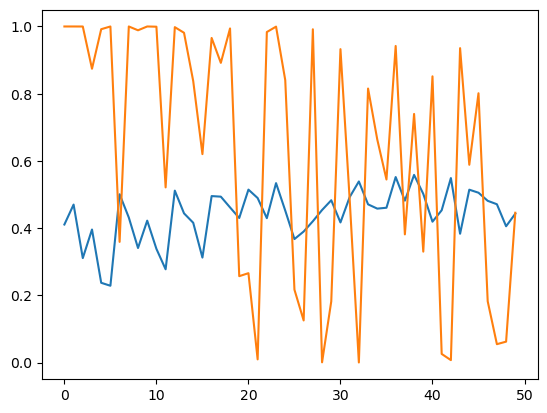

In [24]:
plt.plot(test_acc_list)
plt.plot(asr_list)

### Consolidate the network by applying the pruning

In [25]:
# remove the hooks
anp_system._remove_hooks()

In [26]:
threshold_value = 0.2

In [36]:
# apply pruning
# anp_system._prune_neurons(threshold_value)

with torch.no_grad():
    for name, param in anp_system.model.named_parameters():
        if name.endswith('weight'):
            if name in anp_system.weight_masks:
                param.copy_(param * (anp_system.weight_masks[name] >= threshold_value))

In [42]:
fcw = None

for name, param in anp_system.model.named_parameters():
    if name == 'fc.weight':
        fcw = param

In [46]:
fcw

Parameter containing:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.7063e-02, -2.0504e-03, -1.2732e-01,  ..., -2.1571e-03,
         -8.6177e-02, -4.0504e-02],
        [-3.6286e-02, -2.7053e-03, -8.6574e-02,  ..., -3.0684e-03,
         -8.1642e-02, -5.4987e-02],
        ...,
        [ 1.5387e-01, -5.6252e-04, -6.5462e-02,  ...,  5.4234e-05,
          1.1011e-01,  1.7515e-02],
        [-5.4426e-02, -2.5895e-03,  2.1467e-01,  ..., -2.9225e-03,
          5.5784e-02, -3.6538e-02],
        [-6.0131e-02, -1.7596e-03,  2.6112e-01,  ..., -2.4450e-03,
          5.2251e-02, -1.8673e-03]], device='cuda:0', requires_grad=True)

In [40]:
(anp_system.weight_masks['fc.weight'] >= threshold_value)

tensor([[False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]], device='cuda:0')

In [45]:
fcw * (anp_system.weight_masks['fc.weight'] >= threshold_value)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.7063e-02, -2.0504e-03, -1.2732e-01,  ..., -2.1571e-03,
         -8.6177e-02, -4.0504e-02],
        [-3.6286e-02, -2.7053e-03, -8.6574e-02,  ..., -3.0684e-03,
         -8.1642e-02, -5.4987e-02],
        ...,
        [ 1.5387e-01, -5.6252e-04, -6.5462e-02,  ...,  5.4234e-05,
          1.1011e-01,  1.7515e-02],
        [-5.4426e-02, -2.5895e-03,  2.1467e-01,  ..., -2.9225e-03,
          5.5784e-02, -3.6538e-02],
        [-6.0131e-02, -1.7596e-03,  2.6112e-01,  ..., -2.4450e-03,
          5.2251e-02, -1.8673e-03]], device='cuda:0', grad_fn=<MulBackward0>)

In [47]:
# then test the network once more
# with the rigidly pruned neurons

backdoor_success_ct = 0
backdoor_item_ct = 0
with torch.no_grad():
    for inputs, label in test_loader:
        inputs = introduce_backdoor_test_set(inputs).to(device)
            
        pred = anp_system.model(inputs)
        pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

        # be careful to remove the test dataset items that originally were label 0
        # since we don't want to mix them in with testing backdoor on labels 1-9
        backdoor_success_ct += np.sum((pred_lbls == 0).flatten() & (label.numpy() != 0))
        # backdoor_item_ct += inputs.shape[0]
        backdoor_item_ct += np.sum(label.numpy() != 0)
    
print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')

Backdoor Success Rate: 1.0


### Below are messy debug pokings

##### weight masks values histogram

In [30]:
all_masks_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_values.append(weight_mask_tensor.cpu().detach().numpy().flatten())

all_masks_values = np.concatenate(all_masks_values)

In [31]:
all_masks_values.shape

(9610,)

Text(0, 0.5, 'Number')

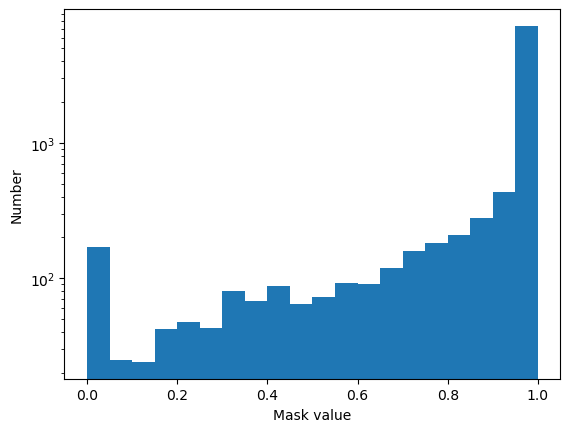

In [32]:
plt.hist(all_masks_values, bins=20, log=True)
plt.xlabel('Mask value')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

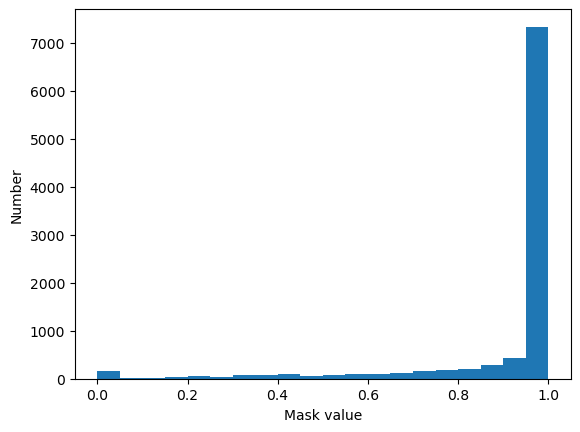

In [33]:
plt.hist(all_masks_values, bins=20)
plt.xlabel('Mask value')
plt.ylabel('Number')

In [34]:
# np.mean(all_masks_values)
np.std(all_masks_values)

np.float32(0.20734791)

In [35]:
all_masks_grad_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_grad_values.append(weight_mask_tensor.grad.cpu().detach().numpy().flatten())

all_masks_grad_values = np.concatenate(all_masks_grad_values)

##### perturbation values histogram

In [ ]:
all_perturbations_values = []

for name in anp_system.weight_perturbations:
    weight_perturbation_tensor = anp_system.weight_perturbations[name]
    all_perturbations_values.append(weight_perturbation_tensor.cpu().detach().numpy().flatten())

all_perturbations_values = np.concatenate(all_perturbations_values)

In [ ]:
all_perturbations_values.shape

In [ ]:
plt.hist(all_perturbations_values, bins=20, log=True)